# Expense Tracker with AWS Textract

### Imports

In [36]:
import boto3
import io
from io import BytesIO
import sys
from time import gmtime, strftime
import re
import time
from string import digits
import json

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import imshow

from PIL import Image, ImageDraw, ImageFont

### Helper Function

In [52]:
def process_receipt(document, bucket = 'textract-expense-tracker', display=False, upload=True, printout=False):
                      
    s3_object = boto3.resource('s3').Object(bucket, document)
    s3_response = s3_object.get()
    stream = io.BytesIO(s3_response['Body'].read())
    bucket_location = boto3.client('s3').get_bucket_location(Bucket=bucket)
    
    ######################################
    #INVOKING TEXTRACT
    ######################################
    text = boto3.client('textract')
    image_binary = stream.getvalue()
    response = text.detect_document_text(Document={'Bytes': image_binary})

    dates = []
    totals = []

    for i, block in enumerate(response["Blocks"]):
        if block["BlockType"] == "LINE":
            date = re.search("[0-3]?[0-9]/[0-3]?[0-9]/(?:[0-9]{2})?[0-9]{2}", block["Text"])
            total = re.search("Total|TOTAL", block["Text"])

            if date is not None: 
                dates.append(date.group())
            if total is not None: 
                total = ''.join(c for c in response["Blocks"][i+1]["Text"] if c in digits+"."+",")
                if total == '':
                    total = ''.join(c for c in response["Blocks"][i-1]["Text"] if c in digits+"."+",")
                totals.append(total.replace(",", "."))

    date = list(set(dates))[0]
    amount = list(set(totals))[0]
    
    if printout:
         print(f"Document: {document}; Date: {date}; Amount: {amount}")
            
    if display: 
        image = Image.open(stream)
        fig, ax = plt.subplots(figsize=(5,10))
        ax.imshow(image)
        plt.show()
    
    ######################################
    #SAVING JSON WITH SENTIMENT TO S3
    ######################################
    content = {            
            'receipt' : f"https://{bucket}.s3-{bucket_location['LocationConstraint']}.amazonaws.com/{document}",
            'submitted_on' : strftime("%Y-%m-%d %H:%M:%S GMT", gmtime()),
            'date' : date,
            'amount' : float(amount)
    }
    
    if upload: boto3.client('s3').put_object(Body=json.dumps(content), Bucket=bucket, Key="textracted/"+document.replace("jpg", "json"));
    
    return

### Running on one receipt

Document: receipt2.jpg; Date: 05/13/2017; Amount: 2.15


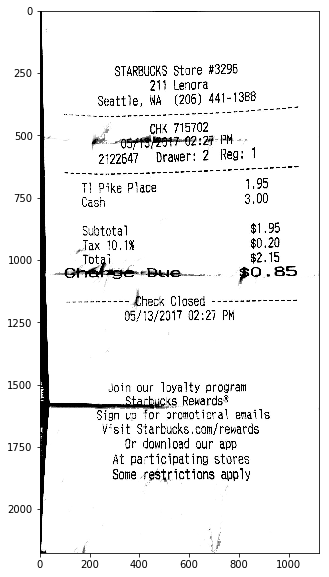

In [57]:
process_receipt('receipt2.jpg', display=True, upload=False, printout=True)

### Running on all receipts and uploading to S3 to ingest the data into QuickSight

In [54]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('textract-expense-tracker')

for receipt in bucket.objects.filter():
    if ".jpg" in receipt.key:
        process_receipt(receipt.key, printout=True)
        time.sleep(2)

Document: receipt1.jpg; Date: 05/10/2017; Amount: 7.60
Document: receipt10.jpg; Date: 5/10/2017; Amount: 49.16
Document: receipt11.jpg; Date: 05/10/2017; Amount: 6.83
Document: receipt12.jpg; Date: 05/10/2017; Amount: 7.60
Document: receipt13.jpg; Date: 05/09/2017; Amount: 8.15
Document: receipt14.jpg; Date: 5/8/17; Amount: 18.72
Document: receipt15.jpg; Date: 05/08/2017; Amount: 2.15
Document: receipt16.jpg; Date: 05/08/2017; Amount: 20.64
Document: receipt17.jpg; Date: 05/08/2017; Amount: 2.48
Document: receipt18.jpg; Date: 05/08/2017; Amount: 7.54
Document: receipt19.jpg; Date: 05/07/2017; Amount: 23.13
Document: receipt2.jpg; Date: 05/13/2017; Amount: 2.15
Document: receipt20.jpg; Date: 08/11/17; Amount: 4.30
Document: receipt22.jpg; Date: 5/14/2017; Amount: 1
Document: receipt23.jpg; Date: 05/13/2017; Amount: 2.15
Document: receipt24.jpg; Date: 05/13/2017; Amount: 3.25
Document: receipt3.jpg; Date: 05/12/2017; Amount: 7.38
Document: receipt4.jpg; Date: 05/12/2017; Amount: 2.64
Doc

### Checking JSON output in S3

In [56]:
s3 = boto3.resource('s3')
content_object = s3.Object('textract-expense-tracker', 'textracted/receipt7.json')
file_content = content_object.get()['Body'].read().decode('utf-8')
json_content = json.loads(file_content)
print(json.dumps(json_content, indent=2))

{
  "receipt": "https://textract-expense-tracker.s3-eu-west-1.amazonaws.com/receipt7.jpg",
  "submitted_on": "2019-06-17 17:42:50 GMT",
  "date": "5/11/2017",
  "amount": 8.81
}
